In [ ]:
import numpy as np
import pandas as pd
from PIL import Image
import datasets
import lightning.pytorch as pl
import torch
import itertools
import timeit
import time
import onnx
import onnxruntime
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
from typing import List

import dm_codes.my_utils
import dm_codes.my_training
import dm_codes.my_datasets

/home/pk/miniconda3/envs/dp-dm-conda/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Predict on test dataset

In [47]:
def prepare_test_dataset(example: dict, random_generator:random.Random) -> dict:
    image: Image.Image = example["image"]
    image = image.resize((128, 128), resample=Image.Resampling.NEAREST)
    angle = random_generator.randint(0, 3) * 90
    image = image.rotate(angle)
    return {"image": image}

In [48]:
# load dataset from hugging face
hf_test_dataset = datasets.load_dataset("shortery/dm-codes")["test"]

In [49]:
random_generator = random.Random(0)

In [ ]:
hf_dataset = hf_test_dataset.map(dm_codes.my_datasets.crop_dm_code)
hf_dataset = hf_dataset.map(lambda x: prepare_test_dataset(x, random_generator))

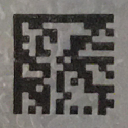

In [51]:
hf_dataset["image"][0]

In [52]:
pd_dataset = pd.DataFrame(hf_dataset)
pd_dataset.head()

,image,tl,tr,br,bl,is_clean,split,text,image_name
0,<PIL.PngImagePlugin.PngImageFile image mode=RG...,"[1680, 1920]","[1656, 1026]","[2547, 1011]","[2571, 1929]",True,test,E51085011W,005.jpg
1,<PIL.PngImagePlugin.PngImageFile image mode=RG...,"[2382, 1983]","[1809, 1938]","[1818, 1311]","[2394, 1338]",False,test,E51085011W,006.jpg
2,<PIL.PngImagePlugin.PngImageFile image mode=RG...,"[2676, 1407]","[2295, 1935]","[1731, 1437]","[2076, 843]",False,test,E51085011W,007.jpg
3,<PIL.PngImagePlugin.PngImageFile image mode=RG...,"[2370, 1719]","[2385, 960]","[3156, 981]","[3159, 1731]",False,test,E51085011W,008.jpg
4,<PIL.PngImagePlugin.PngImageFile image mode=RG...,"[2847, 1713]","[2133, 1923]","[1938, 1086]","[2655, 888]",False,test,E51085011W,009.jpg


In [ ]:
# add new collumn decoded_text
np_grayscale_images = pd_dataset["image"].map(lambda x: np.asarray(x.convert("L")))
pd_dataset["decoded_text_before_nn"] = np_grayscale_images.map(lambda x: dm_codes.my_utils.decode_dm_code(x))
pd_dataset

Exception ignored in: <function _releaseLock at 0x7e7a579c9670>
Traceback (most recent call last):
  File "/home/pk/miniconda3/envs/dp-dm-conda/lib/python3.9/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


In [ ]:
def print_decoding_results(pd_dataset: pd.DataFrame, decoded_text_column: str):
    print("Number of correctly decoded clean codes:", end=" ")
    print(len(pd_dataset[(pd_dataset["is_clean"]) & (pd_dataset[decoded_text_column] == pd_dataset["text"])]), end=" ")
    print("out of", pd_dataset["is_clean"].sum())

    print("Number of undecodable clean codes:", end=" ")
    print(len(pd_dataset[(pd_dataset["is_clean"]) & pd_dataset[decoded_text_column].isna()]), end=" ")
    print("out of", pd_dataset["is_clean"].sum())

    print()

    print("Number of correctly decoded damaged codes:", end=" ")
    print(len(pd_dataset[~(pd_dataset["is_clean"]) & (pd_dataset[decoded_text_column] == pd_dataset["text"])]), end=" ")
    print("out of", (~pd_dataset["is_clean"]).sum())

    print("Number of undecodable damaged codes:", end=" ")
    print(len(pd_dataset[~(pd_dataset["is_clean"]) & pd_dataset[decoded_text_column].isna()]), end=" ")
    print("out of", (~pd_dataset["is_clean"]).sum())


    print("Number of decoded, but not correctly decoded damaged codes:", end=" ")
    print(len(pd_dataset[~(pd_dataset["is_clean"]) & (~pd_dataset[decoded_text_column].isna()) &
                        (pd_dataset[decoded_text_column] != pd_dataset["text"])]), end=" ")
    print("out of", (~pd_dataset["is_clean"]).sum())

    print()
    print("Overall accuracy:")
    num_all = len(pd_dataset)
    num_correctly_decoded = len(pd_dataset[(pd_dataset[decoded_text_column] == pd_dataset["text"])])
    num_decoded = len(pd_dataset[(~pd_dataset[decoded_text_column].isna())])
    print("Decode rate (= correctly_decoded) =", end=" ")
    print(np.round(num_correctly_decoded / num_all, 4))
    print("Misread rate (= decoded - correctly_decoded) =", end=" ")
    print(np.round((num_decoded - num_correctly_decoded) / num_all, 4))

In [ ]:
print("Before network:", end="\n\n")
print_decoding_results(pd_dataset, "decoded_text_before_nn")

Before network:

Number of correctly decoded clean codes: 34 out of 37
Number of undecodable clean codes: 3 out of 37

Number of correctly decoded damaged codes: 29 out of 162
Number of undecodable damaged codes: 129 out of 162
Number of decoded, but not correctly decoded damaged codes: 4 out of 162

Overall accuracy:
Decode rate (= correctly_decoded) = 0.3166
Misread rate (= decoded - correctly_decoded) = 0.0201


In [ ]:
# decoded, but not correctly decoded damaged codes
pd_dataset[~(pd_dataset["is_clean"]) & (~pd_dataset["decoded_text_before_nn"].isna()) &
           (pd_dataset["decoded_text_before_nn"] != pd_dataset["text"])]

,image,tl,tr,br,bl,is_clean,split,text,image_name,decoded_text_before_nn
44,<PIL.PngImagePlugin.PngImageFile image mode=RG...,"[1848, 1497]","[1836, 1296]","[2058, 1308]","[2076, 1512]",False,test,90012107,067.jpg,200707
137,<PIL.PngImagePlugin.PngImageFile image mode=RG...,"[2733, 1500]","[2445, 954]","[2676, 924]","[2973, 1443]",False,test,90442932,207.jpg,90445740
145,<PIL.PngImagePlugin.PngImageFile image mode=RG...,"[2526, 1605]","[2415, 1137]","[2970, 1026]","[3099, 1485]",False,test,90392296,221.jpg,90382296
149,<PIL.PngImagePlugin.PngImageFile image mode=RG...,"[2592, 1503]","[2466, 1200]","[2673, 1215]","[2808, 1512]",False,test,737990,225.jpg,658790


In [ ]:
# prepare dataset to be an input to the network
def preprocess_image(batch):
    return {"image": dm_codes.my_datasets._preprocess(np.asarray(batch["image"]))}

preprocessed_dataset = hf_dataset.map(preprocess_image)

Map: 100%|██████████| 199/199 [00:05<00:00, 36.40 examples/s]  


In [ ]:
# create dataloader
dataloader_test = torch.utils.data.DataLoader(
    dataset=preprocessed_dataset.with_format("torch"),
    batch_size=64
)

In [ ]:
# load model from checkpoint and compute predictions
trainer = pl.Trainer(precision=16)
loaded_model = dm_codes.my_training.LitAutoEncoder.load_from_checkpoint("../checkpoints/serene-wind-199/step=2000--corr_dec=0.5644.ckpt")
loaded_model.eval()
predictions = trainer.predict(loaded_model, dataloader_test)

/home/pk/miniconda3/envs/dp-dm-conda/lib/python3.9/site-packages/lightning/fabric/connector.py:562: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(
Using 16bit Automatic Mixed Precision (AMP)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/pk/miniconda3/envs/dp-dm-conda/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.o

Predicting DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.65it/s]


In [ ]:
# chain all predictions together to get one list
# (otherwise I could iterate it as "for batch in predictions: for pred in batch: ...")
pd_dataset["nn_prediction"] = list(itertools.chain(*predictions))
pd_dataset.head()

,image,tl,tr,br,bl,is_clean,split,text,image_name,decoded_text_before_nn,nn_prediction
0,<PIL.PngImagePlugin.PngImageFile image mode=RG...,"[1680, 1920]","[1656, 1026]","[2547, 1011]","[2571, 1929]",True,test,E51085011W,005.jpg,E51085011W,"[[[tensor(0.9175, dtype=torch.float16), tensor..."
1,<PIL.PngImagePlugin.PngImageFile image mode=RG...,"[2382, 1983]","[1809, 1938]","[1818, 1311]","[2394, 1338]",False,test,E51085011W,006.jpg,None,"[[[tensor(0.9111, dtype=torch.float16), tensor..."
2,<PIL.PngImagePlugin.PngImageFile image mode=RG...,"[2676, 1407]","[2295, 1935]","[1731, 1437]","[2076, 843]",False,test,E51085011W,007.jpg,None,"[[[tensor(0.9438, dtype=torch.float16), tensor..."
3,<PIL.PngImagePlugin.PngImageFile image mode=RG...,"[2370, 1719]","[2385, 960]","[3156, 981]","[3159, 1731]",False,test,E51085011W,008.jpg,None,"[[[tensor(0.9160, dtype=torch.float16), tensor..."
4,<PIL.PngImagePlugin.PngImageFile image mode=RG...,"[2847, 1713]","[2133, 1923]","[1938, 1086]","[2655, 888]",False,test,E51085011W,009.jpg,None,"[[[tensor(0.9136, dtype=torch.float16), tensor..."


In [ ]:
np_prediction_for_image = pd_dataset["nn_prediction"].map(lambda x: np.squeeze(dm_codes.my_utils.tensor_to_numpy_for_image(x.unsqueeze(dim=0))))
pd_dataset["nn_output_image"] = np_prediction_for_image.map(lambda x: Image.fromarray(x, mode="L"))
pd_dataset["decoded_text_after_nn"] = np_prediction_for_image.map(dm_codes.my_utils.decode_dm_code)

In [ ]:
pd_dataset.head()

,image,tl,tr,br,bl,is_clean,split,text,image_name,decoded_text_before_nn,nn_prediction,nn_output_image,decoded_text_after_nn
0,<PIL.PngImagePlugin.PngImageFile image mode=RG...,"[1680, 1920]","[1656, 1026]","[2547, 1011]","[2571, 1929]",True,test,E51085011W,005.jpg,E51085011W,"[[[tensor(0.9175, dtype=torch.float16), tensor...",<PIL.Image.Image image mode=L size=128x128 at ...,E51085011W
1,<PIL.PngImagePlugin.PngImageFile image mode=RG...,"[2382, 1983]","[1809, 1938]","[1818, 1311]","[2394, 1338]",False,test,E51085011W,006.jpg,None,"[[[tensor(0.9111, dtype=torch.float16), tensor...",<PIL.Image.Image image mode=L size=128x128 at ...,None
2,<PIL.PngImagePlugin.PngImageFile image mode=RG...,"[2676, 1407]","[2295, 1935]","[1731, 1437]","[2076, 843]",False,test,E51085011W,007.jpg,None,"[[[tensor(0.9438, dtype=torch.float16), tensor...",<PIL.Image.Image image mode=L size=128x128 at ...,E51085011W
3,<PIL.PngImagePlugin.PngImageFile image mode=RG...,"[2370, 1719]","[2385, 960]","[3156, 981]","[3159, 1731]",False,test,E51085011W,008.jpg,None,"[[[tensor(0.9160, dtype=torch.float16), tensor...",<PIL.Image.Image image mode=L size=128x128 at ...,None
4,<PIL.PngImagePlugin.PngImageFile image mode=RG...,"[2847, 1713]","[2133, 1923]","[1938, 1086]","[2655, 888]",False,test,E51085011W,009.jpg,None,"[[[tensor(0.9136, dtype=torch.float16), tensor...",<PIL.Image.Image image mode=L size=128x128 at ...,None


In [ ]:
print("After network:")
print_decoding_results(pd_dataset, "decoded_text_after_nn")

After network:
Number of correctly decoded clean codes: 34 out of 37
Number of undecodable clean codes: 3 out of 37

Number of correctly decoded damaged codes: 71 out of 162
Number of undecodable damaged codes: 87 out of 162
Number of decoded, but not correctly decoded damaged codes: 4 out of 162

Overall accuracy:
Decode rate (= correctly_decoded) = 0.5276
Misread rate (= decoded - correctly_decoded) = 0.0201


# Measure execution time

In [ ]:
# seed the RNG for all devices (both CPU and CUDA)
torch.manual_seed(0)

# create random tensors as the inputs to the network
random_tensors = torch.rand(size=(64, 3, 128, 128))

In [ ]:
# create dataloader
dataloader_random_tensors = torch.utils.data.DataLoader(
    dataset=[{"image": x} for x in random_tensors],
    batch_size=32
)

In [ ]:
checkpoint_path = "../checkpoints/glowing-snowball-134/step=7500--corr_dec=0.99.ckpt"

trainer = pl.Trainer()
loaded_model = dm_codes.my_training.LitAutoEncoder.load_from_checkpoint(checkpoint_path, map_location=torch.device("cpu"))
loaded_model.eval()

start_wall_time = timeit.default_timer()
start_cpu_time = time.process_time()

predictions = trainer.predict(loaded_model, dataloader_random_tensors)

end_wall_time = timeit.default_timer()
end_cpu_time = time.process_time()

print()
print("wall time:", end_wall_time - start_wall_time, "seconds")
print("cpu time:", end_cpu_time - start_cpu_time, "seconds")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kp/miniconda3/envs/dm-codes/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
/home/kp/miniconda3/envs/dm-codes/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `n

Predicting DataLoader 0: 100%|██████████| 2/2 [00:03<00:00,  1.96s/it]

wall time: 4.236556711024605 seconds
cpu time: 7.305168144 seconds


In [ ]:
# export torch model to onnx
onnx_model_path = "../checkpoints/exported_model.onnx"
torch.onnx.export(
    loaded_model,
    torch.rand(size=(64, 3, 128, 128)),
    onnx_model_path,
    input_names=["image"],
    output_names = ['output'],
    dynamic_axes={'image' : {0 : 'batch_size'}, 'output' : {0 : 'batch_size'}}
)

/home/kp/miniconda3/envs/dm-codes/lib/python3.9/site-packages/segmentation_models_pytorch/base/model.py:16: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if h % output_stride != 0 or w % output_stride != 0:


============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [ ]:
# load onnx model and create inference session
onnx_model = onnx.load(onnx_model_path)
onnx.checker.check_model(onnx_model)
onnx_inference_session = onnxruntime.InferenceSession(onnx_model_path, providers=["CPUExecutionProvider"])

In [ ]:
random_arrays = pd.DataFrame(dataloader_random_tensors).map(np.asarray).to_dict('records')
onnx_predictions = []

start_wall_time = timeit.default_timer()
start_cpu_time = time.process_time()

for random_array in tqdm(random_arrays):
    pred, = onnx_inference_session.run(None, random_array)
    onnx_predictions.append(pred)

end_wall_time = timeit.default_timer()
end_cpu_time = time.process_time()

print()
print("wall time:", end_wall_time - start_wall_time, "seconds")
print("cpu time:", end_cpu_time - start_cpu_time, "seconds")

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


wall time: 2.5878376649925485 seconds
cpu time: 4.860588821 seconds


In [ ]:
# check if the output predictions are the same
np.abs(np.asarray(list(itertools.chain(*predictions))) -
       np.asarray(list(itertools.chain(*onnx_predictions)))).max()

6.735325e-06

# Analyse execution time

In [2]:
pd_runtimes = pd.read_json("../checkpoints_opt_on_real_runtimes.jsonl", lines=True)
pd_runtimes.head()

,checkpoint_path,num_examples,is_onnx,run_on_cpu,wall_time,process_time,median_wall_time,median_process_time,loaded_model_hparams
0,checkpoints/serene-wind-199/step=2000--corr_de...,100,False,False,"[0.002518, 0.002352, 0.002366, 0.0023079999999...","[0.0025169999999999997, 0.002353, 0.002392, 0....",0.002424,0.002415,"{'architecture_config': {'arch': 'Unet', 'enco..."
1,checkpoints/kind-pyramid-200/step=1600--corr_d...,100,False,False,"[0.118265, 0.015300999999999999, 0.012237, 0.0...","[0.11830199999999999, 0.015302, 0.012237999999...",0.012169,0.012175,"{'architecture_config': {'arch': 'Unet', 'enco..."
2,checkpoints/dutiful-star-201/step=2300--corr_d...,100,False,False,"[0.018160000000000003, 0.015382999999999999, 0...","[0.018161, 0.015384, 0.015150000000000002, 0.0...",0.016064,0.016079,"{'architecture_config': {'arch': 'Unet', 'enco..."
3,checkpoints/logical-mountain-202/step=2300--co...,100,False,False,"[0.003705, 0.003492, 0.00337, 0.00374000000000...","[0.003704, 0.003493, 0.00337, 0.00370899999999...",0.003416,0.003419,{'architecture_config': {'arch': 'UnetPlusPlus...
4,checkpoints/golden-bush-203/step=1000--corr_de...,100,False,False,"[0.013460999999999999, 0.01293, 0.013292, 0.01...","[0.013450000000000002, 0.01293, 0.013294, 0.01...",0.013048,0.013030,{'architecture_config': {'arch': 'UnetPlusPlus...


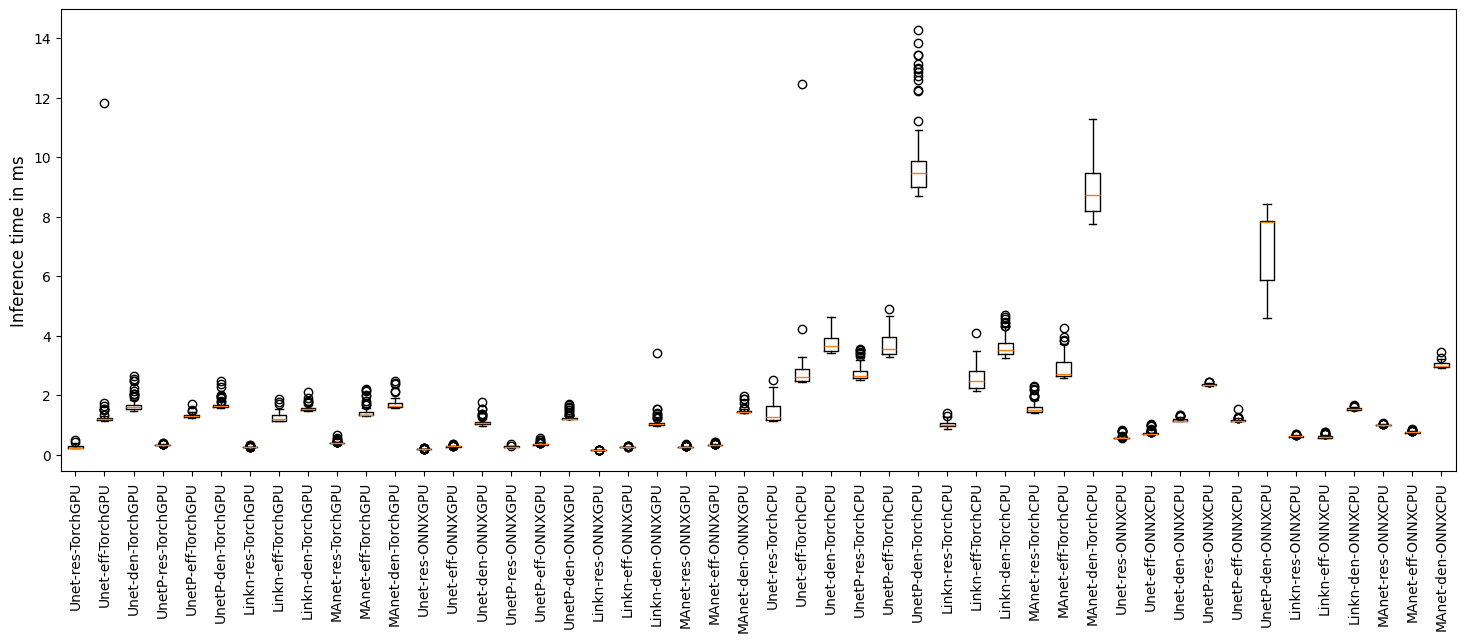

In [3]:
pd_runtimes["wall_time_ms"] = pd_runtimes["wall_time"].apply(
    lambda x: [num * 100 for num in x]
)

labels_all = []
for index, row in pd_runtimes.iterrows():
    label = row["loaded_model_hparams"]["architecture_config"]["arch"][:5]
    label += "-" + row["loaded_model_hparams"]["architecture_config"]["encoder_name"][:3] + "-"
    label += "ONNX" if row["is_onnx"] else "Torch"
    label += "CPU" if row["run_on_cpu"] else "GPU"
    labels_all.append(label)

fig = plt.figure(figsize=(18, 6))
plt.boxplot(pd_runtimes["wall_time_ms"], labels=labels_all)
plt.ylabel("Inference time in ms", fontsize=12)
plt.xticks(rotation=90)
plt.show()

In [4]:
pd_runtimes["mean_wall_time_ms"] = pd_runtimes["wall_time_ms"].apply(np.mean)
pd_runtimes["mean_process_time_ms"] = pd_runtimes["wall_time_ms"].apply(np.mean)

In [5]:
grouped = pd_runtimes.groupby(["run_on_cpu", "is_onnx"])
mean_runtimes = pd.DataFrame(grouped[["mean_wall_time_ms", "mean_process_time_ms"]].mean())
mean_runtimes = mean_runtimes.reset_index()
mean_runtimes

,run_on_cpu,is_onnx,mean_wall_time_ms,mean_process_time_ms
0,False,False,1.104262,1.104262
1,False,True,0.592440,0.592440
2,True,False,3.741868,3.741868
3,True,True,1.720975,1.720975


In [6]:
for col in ["mean_wall_time_ms", "mean_process_time_ms"]:
    print(col.upper())
    mean_torch_gpu = mean_runtimes[~mean_runtimes["run_on_cpu"] & ~mean_runtimes["is_onnx"]][col].item()
    mean_onnx_gpu = mean_runtimes[~mean_runtimes["run_on_cpu"] & mean_runtimes["is_onnx"]][col].item()
    print(f"{mean_torch_gpu=:.4}, {mean_onnx_gpu=:.4}")
    print(f"On average, onnx is {mean_torch_gpu/mean_onnx_gpu:.4} times faster on the gpu.")
    print()
    mean_torch_cpu = mean_runtimes[mean_runtimes["run_on_cpu"] & ~mean_runtimes["is_onnx"]][col].item()
    mean_onnx_cpu = mean_runtimes[mean_runtimes["run_on_cpu"] & mean_runtimes["is_onnx"]][col].item()
    print(f"{mean_torch_cpu=:.4}, {mean_onnx_cpu=:.4}")
    print(f"On average, onnx is {mean_torch_cpu/mean_onnx_cpu:.4} times faster on the cpu.")
    print("-" * 50)

MEAN_WALL_TIME_MS
mean_torch_gpu=1.104, mean_onnx_gpu=0.5924
On average, onnx is 1.864 times faster on the gpu.

mean_torch_cpu=3.742, mean_onnx_cpu=1.721
On average, onnx is 2.174 times faster on the cpu.
--------------------------------------------------
MEAN_PROCESS_TIME_MS
mean_torch_gpu=1.104, mean_onnx_gpu=0.5924
On average, onnx is 1.864 times faster on the gpu.

mean_torch_cpu=3.742, mean_onnx_cpu=1.721
On average, onnx is 2.174 times faster on the cpu.
--------------------------------------------------


In [18]:
# include both experiment 1 and experiment 2 into computing average
# just the wall time
pd_runtimes_1 = pd.read_json("../checkpoints_opt_on_real_runtimes.jsonl", lines=True)
pd_runtimes_1["wall_time_ms"] = pd_runtimes_1["wall_time"].apply(lambda x: [num * 100 for num in x])
pd_runtimes_1["mean_wall_time_ms"] = pd_runtimes_1["wall_time_ms"].apply(np.mean)
pd_runtimes_1 = pd_runtimes_1[['is_onnx', 'run_on_cpu', 'wall_time_ms', 'mean_wall_time_ms']]

pd_runtimes_2 = pd.read_json("../checkpoints_opt_on_real_size_runtimes.jsonl", lines=True)
pd_runtimes_2["wall_time_ms"] = pd_runtimes_2["wall_time"].apply(lambda x: [num * 100 for num in x])
pd_runtimes_2["mean_wall_time_ms"] = pd_runtimes_2["wall_time_ms"].apply(np.mean)
pd_runtimes_2 = pd_runtimes_2[['is_onnx', 'run_on_cpu', 'wall_time_ms', 'mean_wall_time_ms']]

pd_runtimes_1_2 = pd.concat([pd_runtimes_1, pd_runtimes_2])

grouped_1_2 = pd_runtimes_1_2.groupby(["run_on_cpu", "is_onnx"])
mean_runtimes_1_2 = pd.DataFrame(grouped_1_2[["mean_wall_time_ms"]].mean())
mean_runtimes_1_2 = mean_runtimes_1_2.reset_index()
mean_runtimes_1_2

,run_on_cpu,is_onnx,mean_wall_time_ms
0,False,False,1.166338
1,False,True,0.535659
2,True,False,3.912635
3,True,True,1.899154


In [20]:
mean_torch_gpu_1_2 = mean_runtimes_1_2[~mean_runtimes_1_2["run_on_cpu"] & ~mean_runtimes_1_2["is_onnx"]]["mean_wall_time_ms"].item()
mean_onnx_gpu_1_2 = mean_runtimes_1_2[~mean_runtimes_1_2["run_on_cpu"] & mean_runtimes_1_2["is_onnx"]]["mean_wall_time_ms"].item()
print(f"{mean_torch_gpu_1_2=:.4}, {mean_onnx_gpu_1_2=:.4}")
print(f"On average, onnx is {mean_torch_gpu_1_2/mean_onnx_gpu_1_2:.4} times faster on the gpu.")
print()
mean_torch_cpu_1_2 = mean_runtimes_1_2[mean_runtimes_1_2["run_on_cpu"] & ~mean_runtimes_1_2["is_onnx"]]["mean_wall_time_ms"].item()
mean_onnx_cpu_1_2 = mean_runtimes_1_2[mean_runtimes_1_2["run_on_cpu"] & mean_runtimes_1_2["is_onnx"]]["mean_wall_time_ms"].item()
print(f"{mean_torch_cpu_1_2=:.4}, {mean_onnx_cpu_1_2=:.4}")
print(f"On average, onnx is {mean_torch_cpu_1_2/mean_onnx_cpu_1_2:.4} times faster on the cpu.")


mean_torch_gpu_1_2=1.166, mean_onnx_gpu_1_2=0.5357
On average, onnx is 2.177 times faster on the gpu.

mean_torch_cpu_1_2=3.913, mean_onnx_cpu_1_2=1.899
On average, onnx is 2.06 times faster on the cpu.


In [7]:
# Torch median runtimes for experiment 1
pd_runtimes["median_wall_time_ms"] = pd_runtimes["median_wall_time"].apply(lambda x: round(x * 100, 2))
pd_runtimes["arch"] = pd_runtimes["loaded_model_hparams"].apply(lambda x: x["architecture_config"]["arch"])
pd_runtimes["enc"] = pd_runtimes["loaded_model_hparams"].apply(lambda x: x["architecture_config"]["encoder_name"])
median_torch = pd_runtimes[["arch", "enc", "is_onnx", "run_on_cpu", "median_wall_time_ms"]][~pd_runtimes["is_onnx"]].sort_values(["arch", "enc"])
display(median_torch)
print("speedup = cpu - gpu times =")
median_torch[median_torch["run_on_cpu"]]["median_wall_time_ms"].values / median_torch[~median_torch["run_on_cpu"]]["median_wall_time_ms"].values

,arch,enc,is_onnx,run_on_cpu,median_wall_time_ms
8,Linknet,densenet169,False,False,1.55
32,Linknet,densenet169,False,True,3.52
7,Linknet,efficientnet-b3,False,False,1.21
31,Linknet,efficientnet-b3,False,True,2.48
6,Linknet,resnet18,False,False,0.26
30,Linknet,resnet18,False,True,1.02
11,MAnet,densenet169,False,False,1.64
35,MAnet,densenet169,False,True,8.74
10,MAnet,efficientnet-b3,False,False,1.36
34,MAnet,efficientnet-b3,False,True,2.73


speedup = cpu - gpu times =


array([2.27096774, 2.04958678, 3.92307692, 5.32926829, 2.00735294,
       3.8       , 2.26086957, 2.13934426, 5.33333333, 5.76829268,
       2.73076923, 7.85294118])

In [8]:
# ONNX median runtimes for experiment 1
pd_runtimes["median_wall_time_ms"] = pd_runtimes["median_wall_time"].apply(lambda x: round(x * 100, 2))
pd_runtimes["arch"] = pd_runtimes["loaded_model_hparams"].apply(lambda x: x["architecture_config"]["arch"])
pd_runtimes["enc"] = pd_runtimes["loaded_model_hparams"].apply(lambda x: x["architecture_config"]["encoder_name"])
median_torch = pd_runtimes[["arch", "enc", "is_onnx", "run_on_cpu", "median_wall_time_ms"]][pd_runtimes["is_onnx"]].sort_values(["arch", "enc"])
display(median_torch)
print("speedup = cpu - gpu times =")
median_torch[median_torch["run_on_cpu"]]["median_wall_time_ms"].values / median_torch[~median_torch["run_on_cpu"]]["median_wall_time_ms"].values

,arch,enc,is_onnx,run_on_cpu,median_wall_time_ms
20,Linknet,densenet169,True,False,1.03
44,Linknet,densenet169,True,True,1.53
19,Linknet,efficientnet-b3,True,False,0.26
43,Linknet,efficientnet-b3,True,True,0.59
18,Linknet,resnet18,True,False,0.15
42,Linknet,resnet18,True,True,0.63
23,MAnet,densenet169,True,False,1.46
47,MAnet,densenet169,True,True,3.00
22,MAnet,efficientnet-b3,True,False,0.35
46,MAnet,efficientnet-b3,True,True,0.75


speedup = cpu - gpu times =


array([1.48543689, 2.26923077, 4.2       , 2.05479452, 2.14285714,
       3.7037037 , 1.09433962, 2.44827586, 2.8       , 6.40163934,
       3.28571429, 8.39285714])

In [9]:
# Torch median runtimes for experiment 2 encoder sizes
pd_real_size_runtimes = pd.read_json("../checkpoints_opt_on_real_size_runtimes.jsonl", lines=True)
pd_real_size_runtimes["median_wall_time_ms"] = pd_real_size_runtimes["median_wall_time"].apply(lambda x: round(x * 100, 2))
pd_real_size_runtimes["arch"] = pd_real_size_runtimes["loaded_model_hparams"].apply(lambda x: x["architecture_config"]["arch"])
pd_real_size_runtimes["enc"] = pd_real_size_runtimes["loaded_model_hparams"].apply(lambda x: x["architecture_config"]["encoder_name"])
median_torch_sizes = pd_real_size_runtimes[["arch", "enc", "is_onnx", "run_on_cpu", "median_wall_time_ms"]][~pd_real_size_runtimes["is_onnx"]].sort_values(["arch", "enc"])
display(median_torch_sizes)
print("speedup = cpu - gpu times =")
median_torch_sizes[median_torch_sizes["run_on_cpu"]]["median_wall_time_ms"].values / median_torch_sizes[~median_torch_sizes["run_on_cpu"]]["median_wall_time_ms"].values

,arch,enc,is_onnx,run_on_cpu,median_wall_time_ms
0,UnetPlusPlus,efficientnet-b0,False,False,0.92
16,UnetPlusPlus,efficientnet-b0,False,True,2.12
1,UnetPlusPlus,efficientnet-b3,False,False,1.23
17,UnetPlusPlus,efficientnet-b3,False,True,3.34
2,UnetPlusPlus,efficientnet-b6,False,False,2.20
18,UnetPlusPlus,efficientnet-b6,False,True,6.16
3,UnetPlusPlus,efficientnet-b7,False,False,2.60
19,UnetPlusPlus,efficientnet-b7,False,True,7.94
5,UnetPlusPlus,mobilenet_v2,False,False,0.62
21,UnetPlusPlus,mobilenet_v2,False,True,1.71


speedup = cpu - gpu times =


array([ 2.30434783,  2.71544715,  2.8       ,  3.05384615,  2.75806452,
       12.84126984,  2.43478261,  2.03030303])

In [10]:
# ONNX median runtimes for experiment 2 encoder sizes
pd_real_size_runtimes = pd.read_json("../checkpoints_opt_on_real_size_runtimes.jsonl", lines=True)
pd_real_size_runtimes["median_wall_time_ms"] = pd_real_size_runtimes["median_wall_time"].apply(lambda x: round(x * 100, 2))
pd_real_size_runtimes["arch"] = pd_real_size_runtimes["loaded_model_hparams"].apply(lambda x: x["architecture_config"]["arch"])
pd_real_size_runtimes["enc"] = pd_real_size_runtimes["loaded_model_hparams"].apply(lambda x: x["architecture_config"]["encoder_name"])
median_torch_sizes = pd_real_size_runtimes[["arch", "enc", "is_onnx", "run_on_cpu", "median_wall_time_ms"]][pd_real_size_runtimes["is_onnx"]].sort_values(["arch", "enc"])
display(median_torch_sizes)
print("speedup = cpu - gpu times =")
median_torch_sizes[median_torch_sizes["run_on_cpu"]]["median_wall_time_ms"].values / median_torch_sizes[~median_torch_sizes["run_on_cpu"]]["median_wall_time_ms"].values

,arch,enc,is_onnx,run_on_cpu,median_wall_time_ms
8,UnetPlusPlus,efficientnet-b0,True,False,0.28
24,UnetPlusPlus,efficientnet-b0,True,True,0.74
9,UnetPlusPlus,efficientnet-b3,True,False,0.35
25,UnetPlusPlus,efficientnet-b3,True,True,1.17
10,UnetPlusPlus,efficientnet-b6,True,False,0.58
26,UnetPlusPlus,efficientnet-b6,True,True,3.27
11,UnetPlusPlus,efficientnet-b7,True,False,0.74
27,UnetPlusPlus,efficientnet-b7,True,True,2.85
13,UnetPlusPlus,mobilenet_v2,True,False,0.22
29,UnetPlusPlus,mobilenet_v2,True,True,0.76


speedup = cpu - gpu times =


array([ 2.64285714,  3.34285714,  5.63793103,  3.85135135,  3.45454545,
       10.35135135,  2.23333333,  1.92      ])

In [11]:
# Load runtimes for experiment 2 encoder sizes
df_real_size_runtimes = pd.read_json("../checkpoints_opt_on_real_size_runtimes.jsonl", lines=True)
# convert seconds to milliseconds
df_real_size_runtimes["wall_time_ms"] = df_real_size_runtimes["wall_time"].apply(
    lambda x: [num * 100 for num in x]
)

In [12]:
for ckpt in df_real_size_runtimes["checkpoint_path"].unique():
    print(ckpt)

checkpoints/swept-snowball-211/step=900--corr_dec=0.5446.ckpt
checkpoints/golden-bush-203/step=1000--corr_dec=0.5545.ckpt
checkpoints/charmed-plant-213/step=1600--corr_dec=0.5644.ckpt
checkpoints/zany-deluge-215/step=1300--corr_dec=0.5446.ckpt
checkpoints/snowy-fire-216/step=1100--corr_dec=0.5347.ckpt
checkpoints/swept-gorge-217/step=1600--corr_dec=0.5644.ckpt
checkpoints/warm-mountain-218/step=500--corr_dec=0.5248.ckpt
checkpoints/dazzling-field-219/step=1200--corr_dec=0.5545.ckpt


In [13]:
ckpt_path_unet_pp_eff_b3 = "checkpoints/golden-bush-203/step=1000--corr_dec=0.5545.ckpt"
ckpt_path_unet_pp_eff_b0 = "checkpoints/swept-snowball-211/step=900--corr_dec=0.5446.ckpt"
ckpt_path_unet_pp_eff_b6 = "checkpoints/charmed-plant-213/step=1600--corr_dec=0.5644.ckpt"
ckpt_path_mobilenet_small = "checkpoints/snowy-fire-216/step=1100--corr_dec=0.5347.ckpt"

In [14]:
def plot_inference_time_boxplot(checkpoint_path: str, df_runtimes: pd.DataFrame):
    df_checkpoint = df_runtimes[df_runtimes["checkpoint_path"] == checkpoint_path]
    sorted_df_checkpoint = df_checkpoint.sort_values(["run_on_cpu", "is_onnx"])

    labels = []
    for index, row in sorted_df_checkpoint.iterrows():
        label = ""
        label += "ONNX" if row["is_onnx"] else "Torch"
        label += " "
        label += "CPU" if row["run_on_cpu"] else "GPU"
        labels.append(label)

    h_params = df_checkpoint["loaded_model_hparams"].values[0]["architecture_config"]

    fig = plt.figure(figsize=(6, 5))
    plt.boxplot(df_checkpoint["wall_time_ms"], labels=labels)
    plt.ylabel("Inference time in ms", fontsize=12)
    plt.title(f"Inference time for one prediction \n (architecture {h_params['arch']}, encoder {h_params['encoder_name']})", fontsize=12)
    plt.tick_params(axis='x', labelsize=12)
    plt.show()

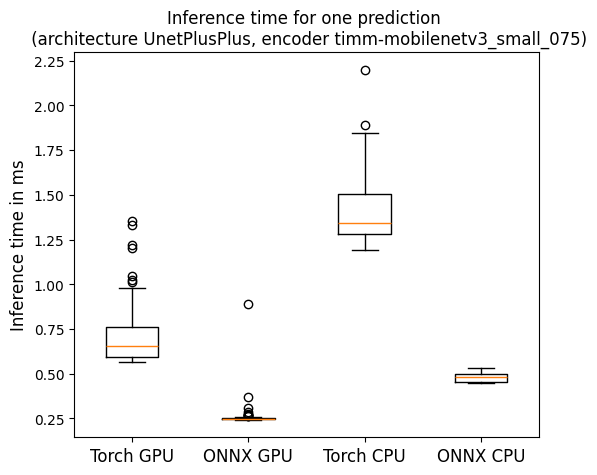

In [15]:
plot_inference_time_boxplot(ckpt_path_mobilenet_small, df_real_size_runtimes)

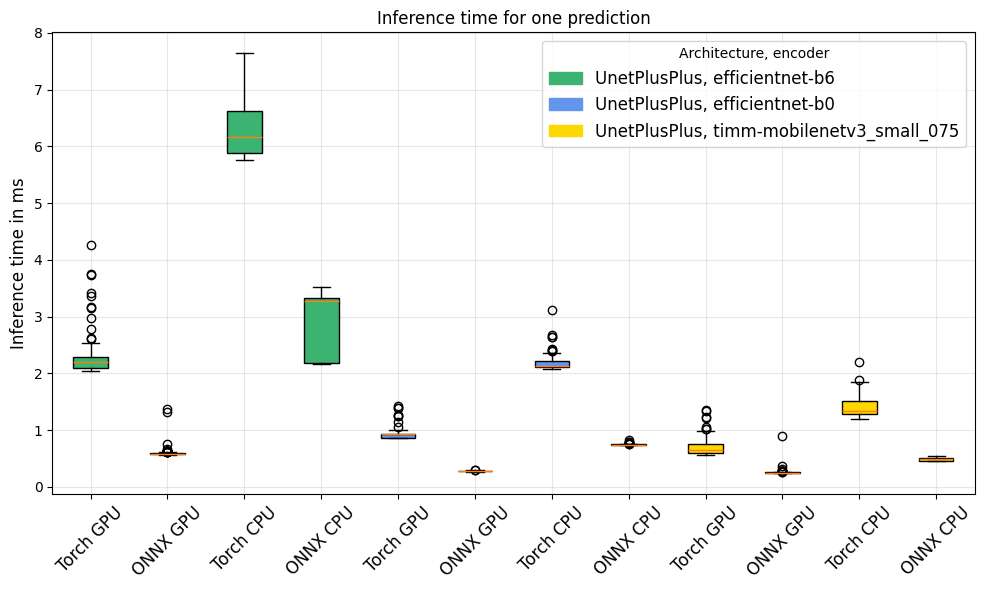

In [16]:
def plot_inference_time_boxplot(checkpoint_paths: List[str], checkpoint_names: List[str], colors: dict, df_runtimes: pd.DataFrame):
    fig, ax = plt.subplots(figsize=(10, 6))

    all_labels = []
    all_wall_times = []

    position_counter = 1  # Counter for setting positions of boxplots

    for checkpoint_path in checkpoint_paths:
        df_checkpoint = df_runtimes[df_runtimes["checkpoint_path"] == checkpoint_path]
        sorted_df_checkpoint = df_checkpoint.sort_values(["run_on_cpu", "is_onnx"])

        labels = []
        checkpoint_labels = []  # Labels for checkpoint level
        for index, row in sorted_df_checkpoint.iterrows():
            label = "ONNX" if row["is_onnx"] else "Torch"
            label += " "
            label += "CPU" if row["run_on_cpu"] else "GPU"
            labels.append(label)
            checkpoint_labels.append(checkpoint_path)  # Append the checkpoint label
        
        all_labels.extend(labels)
        all_wall_times.append(df_checkpoint["wall_time_ms"])

        # Set positions for the boxplots
        positions = range(position_counter, position_counter + len(labels))
        position_counter += len(labels)

        # Plot the boxplots with respective colors
        ax.boxplot(df_checkpoint["wall_time_ms"], positions=positions, labels=labels, patch_artist=True, boxprops=dict(facecolor=colors[checkpoint_path]))

    # Add the checkpoint path labels as a second level on the x-axis
    ax.set_xticks(range(1, position_counter))
    ax.set_xticklabels(all_labels, rotation=45, fontsize=12)  # Set the labels
    
    ax.set_ylabel("Inference time in ms", fontsize=12)
    ax.set_title("Inference time for one prediction", fontsize=12)
    plt.tight_layout()  # Adjust layout to prevent overlapping

    # Create legend
    legend_handles = [plt.Rectangle((0,0),1,1, color=color) for color in colors.values()]
    ax.legend(legend_handles, checkpoint_names, loc='upper right', title='Architecture, encoder', fontsize=12)

    plt.grid(True, axis="both", alpha=0.3)
    plt.show()


checkpoint_paths = [ckpt_path_unet_pp_eff_b6, ckpt_path_unet_pp_eff_b0, ckpt_path_mobilenet_small]
checkpoint_names = ["UnetPlusPlus, efficientnet-b6", "UnetPlusPlus, efficientnet-b0", "UnetPlusPlus, timm-mobilenetv3_small_075"]
colors = {ckpt_path_unet_pp_eff_b6: 'mediumseagreen', ckpt_path_unet_pp_eff_b0: 'cornflowerblue', ckpt_path_mobilenet_small: 'gold'}
plot_inference_time_boxplot(checkpoint_paths, checkpoint_names, colors, df_real_size_runtimes)


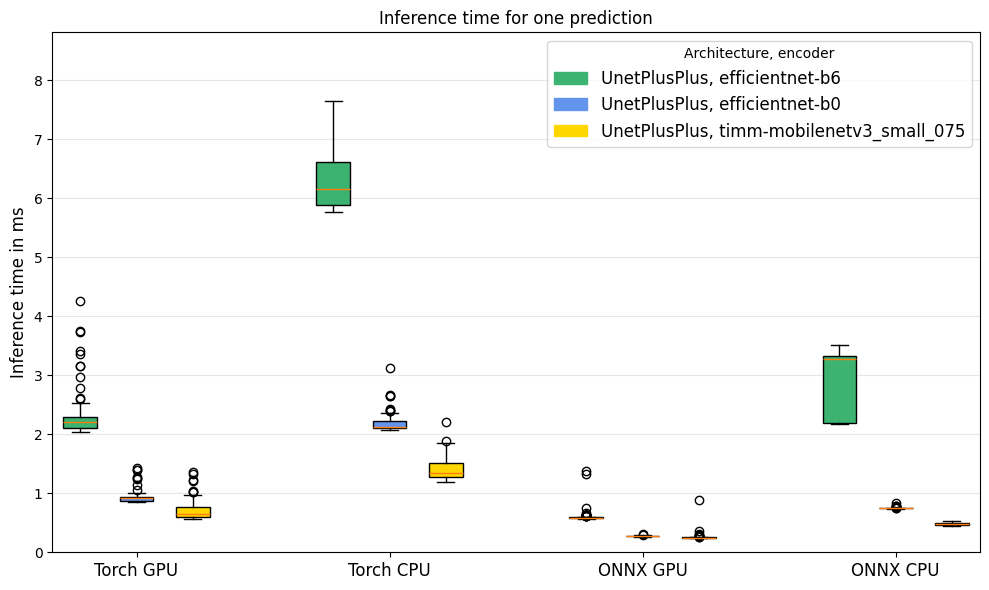

In [17]:
def plot_inference_time_boxplot2(checkpoint_paths: List[str], checkpoint_names: List[str], colors: dict, df_runtimes: pd.DataFrame):
    fig, ax = plt.subplots(figsize=(10, 6))

    all_labels = []
    all_wall_times = []

    position_counter = 1  # Counter for setting positions of boxplots

    # Define the desired order of categories
    desired_order = ["Torch GPU", "Torch CPU", "ONNX GPU", "ONNX CPU"]

    group_labels = []  # Labels for each group of three boxplots
    group_positions = []  # Positions for each group of three boxplots

    for idx, category in enumerate(desired_order):
        category_positions = []  # Positions for each boxplot within the category

        for checkpoint_path in checkpoint_paths:
            df_checkpoint = df_runtimes[(df_runtimes["checkpoint_path"] == checkpoint_path) & (df_runtimes["run_on_cpu"] == (category.endswith("CPU"))) & (df_runtimes["is_onnx"] == (category.startswith("ONNX")))]
            if not df_checkpoint.empty:
                labels = [category] * len(df_checkpoint)
                all_labels.extend(labels)
                all_wall_times.append(df_checkpoint["wall_time_ms"])

                # Set positions for the boxplots with additional space for each group
                positions = [position_counter + idx * 1.5] * len(labels)
                position_counter += len(labels)
                category_positions.extend(positions)

                # Plot the boxplots with respective colors
                ax.boxplot(df_checkpoint["wall_time_ms"], positions=positions, labels=labels, patch_artist=True, boxprops=dict(facecolor=colors[checkpoint_path]), widths=0.6)

        # Calculate the position for the category label
        if category_positions:
            category_position = sum(category_positions) / len(category_positions)
            group_labels.append(category)
            group_positions.append(category_position)

    # Set x-axis ticks and labels for each group of three boxplots
    ax.set_xticks(group_positions)
    ax.set_xticklabels(group_labels, fontsize=12)

    ax.set_ylabel("Inference time in ms", fontsize=12)
    ax.set_title("Inference time for one prediction", fontsize=12)

    # Adjust y-axis limits to add vertical space before the first group and after the last group
    ax.set_ylim(bottom=0)  # Ensure the lower limit starts from 0
    ax.set_ylim(top=ax.get_ylim()[1] * 1.1)  # Increase upper limit by 10%

    plt.tight_layout()  # Adjust layout to prevent overlapping

    # Create legend
    legend_handles = [plt.Rectangle((0,0),1,1, color=color) for color in colors.values()]
    ax.legend(legend_handles, checkpoint_names, loc='upper right', title='Architecture, encoder', fontsize=12)

    plt.grid(True, axis="y", alpha=0.3)
    plt.show()


checkpoint_paths = [ckpt_path_unet_pp_eff_b6, ckpt_path_unet_pp_eff_b0, ckpt_path_mobilenet_small]
checkpoint_names = ["UnetPlusPlus, efficientnet-b6", "UnetPlusPlus, efficientnet-b0", "UnetPlusPlus, timm-mobilenetv3_small_075"]
colors = {ckpt_path_unet_pp_eff_b6: 'mediumseagreen', ckpt_path_unet_pp_eff_b0: 'cornflowerblue', ckpt_path_mobilenet_small: 'gold'}
plot_inference_time_boxplot2(checkpoint_paths, checkpoint_names, colors, df_real_size_runtimes)

# Summary plots

In [52]:
def create_overall_scatterplot(
    accuracy_path: str,
    runtime_path: str,
    trainable_params: List[int],
    x_lim: tuple[int],
    y_lim: tuple[int]
    ):
    # read json to tables
    pd_summary_accuracies = pd.read_json(accuracy_path, lines=True)
    pd_summary_runtimes = pd.read_json(runtime_path, lines=True)

    # choose torch gpu models
    pd_runtimes_torch_gpu = pd_summary_runtimes[~pd_summary_runtimes["is_onnx"] & ~pd_summary_runtimes["run_on_cpu"]]
    
    # merge accuracies and runtime tables
    pd_summary = pd_summary_accuracies.merge(pd_runtimes_torch_gpu[["checkpoint_path", "median_wall_time"]], on="checkpoint_path")
    
    # add trainable parameters
    pd_summary["trainable_params"] = trainable_params
    
    # convert seconds to milliseconds
    pd_summary["median_wall_time_ms"] = pd_summary["median_wall_time"].apply(lambda x: x * 100)


    # Define a color map for each architecture
    color_maps_archs = {
        'Unet': plt.cm.Blues,
        'UnetPlusPlus': plt.cm.Greens,
        'Linknet': plt.cm.Oranges,
        'MAnet': plt.cm.Purples
    }
    color_maps_encs = {
        'efficientnet': plt.cm.PuBuGn,
        'mobilenet': plt.cm.PuRd,
        'resnet50': plt.cm.YlOrBr,
    }
    
    # choose features for plotting
    try:
        pd_summary["after_nndecode_rate"]
        decode_rate_col = "after_nndecode_rate"
        color_maps = color_maps_archs
    except:
        pd_summary["after_nn_decode_rate"]
        decode_rate_col = "after_nn_decode_rate"
        color_maps = color_maps_encs

    pd_plot_summary = pd_summary[["architecture", "encoder", decode_rate_col, "median_wall_time_ms", "trainable_params"]]
    

    plt.figure(figsize=(6, 4))

    
    if color_maps == color_maps_archs:
        # Scatter plot with different colors for each combination of "architecture" and "encoder"
        for arch, color_map in color_maps_archs.items():
            arch_data = pd_plot_summary[pd_plot_summary['architecture'] == arch]
            unique_encoders = arch_data['encoder'].unique()
            colors = color_map(np.linspace(0.4, 1, len(unique_encoders)))  # Start from 0.4 for darker shades
            for i, encoder in enumerate(unique_encoders):
                encoder_data = arch_data[arch_data['encoder'] == encoder]
                plt.scatter(encoder_data[decode_rate_col], encoder_data['median_wall_time_ms'], s=encoder_data['trainable_params']*20, alpha=0.5, label=f'{arch}, {encoder}', color=colors[i])
    
    elif color_maps == color_maps_encs:
        # Scatter plot with different colors for each "encoder" variant
        for enc_substr, color_map in color_maps_encs.items():
            enc_data = pd_plot_summary[pd_plot_summary['encoder'].str.contains(enc_substr)]
            unique_encoders = enc_data['encoder'].unique()
            colors = color_map(np.linspace(0.4, 1, len(unique_encoders)))  # Generate shades of color
            for i, encoder in enumerate(unique_encoders):
                encoder_data = enc_data[enc_data['encoder'] == encoder]
                color = colors[i]  # Get a different shade for each encoder
                plt.scatter(encoder_data[decode_rate_col], encoder_data['median_wall_time_ms'], s=encoder_data['trainable_params']*20, alpha=0.5, label=f'{encoder}', color=color)

    # Add labels and title
    plt.xlabel('Decode rate', fontsize=12)
    plt.ylabel('Median inference time in ms', fontsize=12)
    plt.title('Scatter plot of the decode rate vs inference time', fontsize=12)

    # Set axis limits
    plt.xlim(x_lim[0], x_lim[1])
    plt.ylim(y_lim[0], y_lim[1])

    # Add legend outside the plot
    legend = plt.legend(bbox_to_anchor=(1, 1), loc='upper left', markerscale=1, fontsize=11)
    for handle in legend.legendHandles:
        handle.set_sizes([80])

    # Show the plot
    plt.show()


/tmp/ipykernel_3423301/4020497139.py:86: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


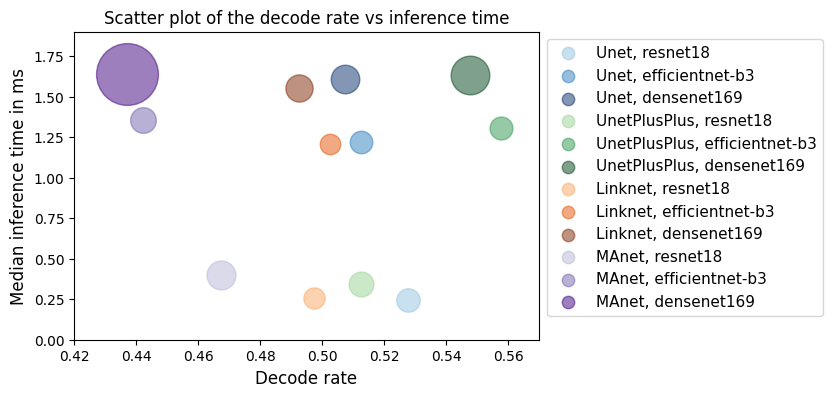

In [53]:
# experiment 1 table
create_overall_scatterplot(
    accuracy_path="../checkpoints_opt_on_real_accuracies.jsonl",
    runtime_path="../checkpoints_opt_on_real_runtimes.jsonl",
    trainable_params=[14.3, 13.2, 21.2, 16.0, 13.6, 38.8, 11.7, 10.9, 19.2, 21.7, 17.2, 99.2],
    x_lim=(0.420, 0.570),
    y_lim=(0, 1.9)
)

/tmp/ipykernel_3423301/4020497139.py:86: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


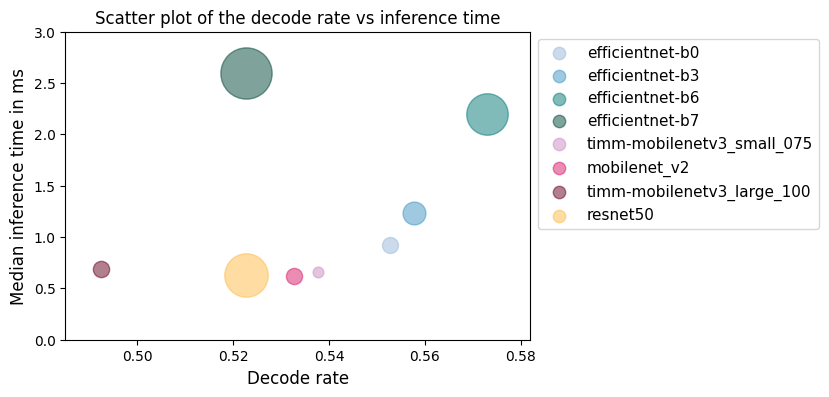

In [54]:
# experiment 2 table
create_overall_scatterplot(
    accuracy_path="../checkpoints_opt_on_real_size_accuracies.jsonl",
    runtime_path="../checkpoints_opt_on_real_size_runtimes.jsonl",
    trainable_params=[6.6, 13.6, 44.7, 68.2, 3.0, 6.8, 6.9, 49.0],
    x_lim=(0.485, 0.582),
    y_lim=(0, 3)
)